## Optimizing Model Complexity

In [1]:
import numpy as np
import pandas as pd
import torch
from math import pi,exp

import matplotlib.pyplot as plt
%matplotlib inline

### Load the Data

Read the training data from file scores-train_1.csv. The first two columns are x1 and x2. The last column holds the class label y. Loads the data into pytorch tensors.

In [2]:
trainset = pd.read_csv('scores_train_1.csv',names=['x1','x2','y'])
testset = pd.read_csv('scores_test_1.csv',names=['x1','x2','y'])
testset.head()

,x1,x2,y
0,78.516966,94.878423,1.0
1,9.224115,22.703113,0.0
2,69.559562,27.404855,0.0
3,52.709790,51.388192,1.0
4,54.293136,82.018288,1.0


In [3]:
z = trainset.to_numpy()
xtrain0 = torch.tensor(z[:, 0:2]).reshape(-1,2)
ytrain = torch.tensor(z[:, 2]).reshape(-1,1)

z = testset.to_numpy()
xtest0 = torch.tensor(z[:,0:2]).reshape(-1,2)
ytest = torch.tensor(z[:, 2]).reshape(-1,1)

# normalize
mu = torch.mean(xtrain0,dim=0).reshape(1,2)
stdev = torch.std(xtrain0,dim=0).reshape(1,2)
xtrain = (xtrain0-mu)/stdev
xtest = (xtest0-mu)/stdev

print("Training Set: ", xtrain.shape, ytrain.shape)
print("Test Set:     ", xtest.shape, ytest.shape)

Training Set:  torch.Size([100, 2]) torch.Size([100, 1])
Test Set:      torch.Size([100, 2]) torch.Size([100, 1])


### Plotting Utilities

Plot the training data using a scatter plot.
The model function that can be passed will be used later to draw decision boundaries. 

In [4]:
def plot_dataset(x, y, model=None):
    n = x.shape[0]
    x1 = x[:,0].numpy()
    x2 = x[:,1].numpy()
    plot_data(x1,x2,y, model)
        
def add_decision_boundary(x1min, x1max, x2min, x2max, model,ax):
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, (x1max-x1min)/100), np.arange(x2min, x2max, (x2max-x2min)/100))
    xx10 = torch.tensor(xx1).reshape(xx1.size,1)
    xx20 = torch.tensor(xx2).reshape(xx2.size,1)
    xx = torch.cat([xx10, xx20], axis=1) 
    yy = model(xx).reshape(xx1.shape)
    ax.contour(xx1, xx2, yy.numpy(), levels=[0], cmap=plt.cm.Paired)
    
def plot_data(x1,x2,y, model=None):
    indices_pass = np.where(y[:,0]==1)
    indices_fail = np.where(y[:,0]==0)
    x1_pass = x1[indices_pass]
    x2_pass = x2[indices_pass]
    x1_fail = x1[indices_fail]
    x2_fail = x2[indices_fail]
    f, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(x1_fail,x2_fail,marker='o',color='green',label='not admitted')
    ax.scatter(x1_pass,x2_pass,marker='x',color='red',label='admitted')
    plt.xlabel('Exam 1 score $x_1$')
    plt.ylabel('Exam 2 score $x_2$')
    axes = plt.gca()    
    
    if model:
        add_decision_boundary(-2.0,2.0,-2.0,2.0,model,ax)
    
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

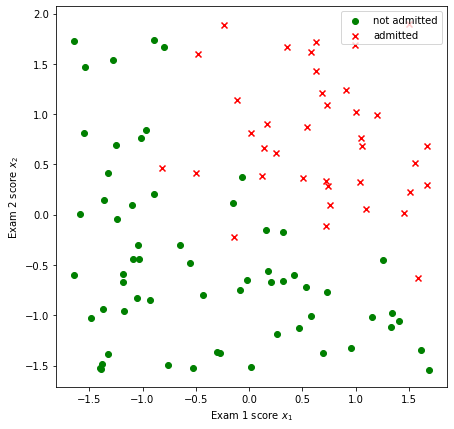

<Figure size 432x288 with 0 Axes>

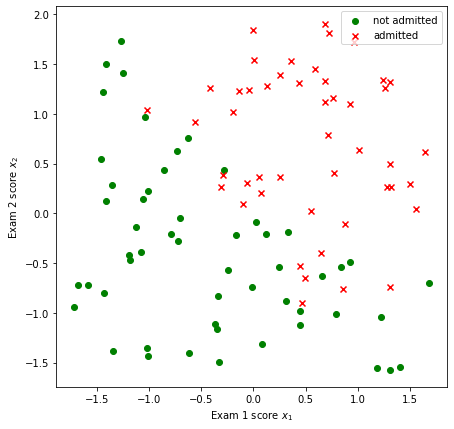

In [5]:
plt.figure(1)
plot_dataset(xtrain, ytrain)

plt.figure(2)
plot_dataset(xtest, ytest)

### Modelling

We consider different models of different complexities involving different number of parameters. All these models involve combinations of powers in $x_1,x_2$ and are of the form

$\quad g(x_1,x_2) = \sigma(h(x_1,x_2)), \quad h(x_1,x_2)=\sum_{k=0}^n w_k \phi_k(x_1,x_2)$

with $\phi_k$  multinomials in $x_1,x_2$ (i.e. combinations of powers in $x_1,x_2$). The decision boundary is then given by $h(x_1,x_2)=0$. This can be formulated by a linear model of the form $\mathbf{W}\cdot\mathbf{x}$ by adding different dimensions to the input data with suitable powers of the prime input data $x_1,x_2$.

Specifically, we consider the following situations:

* Linear Affine: $h(x_1,x_2) = b_0 + w_1x_1 + w_2x_2$ where $\mathbf{x}=(1,x_1,x_2)$

* Quadratic: $h_2(x_1,x_2) = b_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5$ where $\mathbf{x}=(1,x_1,x_2,x_1^2,x_2^2,x_1x_2)$

* etc.

All the above models are linear in the parameters. We can use the same optimisation function.

The method `polynomial_features` below will help you to extend the input dataset by additional dimensions up to a given polynomial order.

In [6]:
def polynomial_features(x, order):
    """
    Arguments:
    x -- pytorch input tensor of shape (m,2) where m is the number of samples
    order -- the max order of terms to be added (x1^j*x2^i and i+j<=order)
    
    Returns:
    pytorch tensor of shape (m,n) where n = (order+1)*(order+2)/2 (all the monomials x1^j*x2^i and i+j<=order)
    """
    m = x.shape[0]
    n = 3    
    x1,x2 = x[:,0].reshape(m,1),x[:,1].reshape(m,1)
    features = torch.cat([torch.ones((m,1),dtype=torch.float),x1,x2], dim=1)
    if order > 1:
        for i in range(2,order+1):
            for term in range(i+1):
                features = torch.cat([features, (x1**(i-term)*x2**term).reshape(m,1)], axis=1)
                n += 1
    return features

### Predict, Optimize

In [7]:
def initialize_weights(n):
    return torch.randn(size=(1,n), dtype=torch.double)*0.01

In [8]:
# Auxiliary methods possibly suited for performing the optimize-step below

def predict(X,W):
    """
    X - pytorch tensor of shape (m,n)
    W - pytorch tensor of shape (1,n)
    Returns pytorch tensor of shape (m,1) with the logistic regression probabilities
    """
    ### START YOUR CODE
    return torch.div(1, torch.add(1, torch.exp(-(X@W.T))))
    
    
    ### END YOUR CODE

def cost(A,Y):
    return -torch.mean(Y*np.log(A+eps)+(1-Y)*np.log(1-A+eps))

def error_rate(A, Y):
    Ypred = torch.round(A)
    return torch.sum(Y != Ypred) / Y.shape[0]

eps = 1.0e-8
def gradient_cost(A,X,Y):
    ### START YOUR CODE

    
    return -(1/len(Y)) * torch.sum(Y*torch.log(torch.abs(predict(X,A))+eps) + (1-Y)*torch.log(torch.abs(1-predict(X,A))+eps))
    
    
    ### END YOUR CODE


In [9]:
def optimize(Xtrain,Ytrain,Xtest,Ytest,nepochs,learningrate):
    """
    Implements (batch) gradient descent for minimizing cross-entropy cost. It returns the learning curves 
    for cost and error rate (test and training). The curves are returned as numpy array of lenghth nepochs+1 
    (the +1 for the initial values).  
    
    Arguments:
    Xtrain -- input data for training, pytorch tensor with shape (m,n)
    Ytrain -- labels for training, pytorch tensor with shape (m,1)
    Xtest -- input data for test, pytorch tensor with shape (m,n)
    Ytest -- labels for test, pytorch tensor with shape (m,1)
    nepochs -- number of epochs
    learningrate -- learning rate
    
    Returns:
    traincosts -- learning curve with the cost on the training dataset, a pytorch tensor of shape (nepochs+1)
    testcosts -- learning curve with the cost on the test dataset, a pytorch tensor of shape (nepochs+1) 
    trainerror -- learning curve with the error rate on the training dataset, a pytorch tensor of shape (nepochs+1)
    testerror -- learning curve with the error rate on the test dataset, a pytorch tensor of shape (nepochs+1)
    W -- parameter vector, a pytorch tensor of shape (1,n+1)
    """
    
    ### START YOUR CODE
    
    W = torch.randn((1,Xtrain.shape[1]), dtype=torch.double)
    
    traincosts = torch.zeros((nepochs+1))
    testcosts = torch.zeros((nepochs+1))
    trainerror = torch.zeros((nepochs+1))
    testerror = torch.zeros((nepochs+1))
    
    for epoch in range(nepochs):
        dw = gradient_cost(W, Xtrain, Ytrain)
        W = torch.sub(W, learningrate * dw)
        traincosts[epoch+1] = cost(predict(Xtrain, W),Ytrain)
        trainerror[epoch+1] = error_rate(predict(Xtrain, W),Ytrain)
        
        testcosts[epoch+1] = cost(predict(Xtest, W),Ytest)
        testerror[epoch+1] = error_rate(predict(Xtest, W),Ytest)
    
    return traincosts, testcosts, trainerror, testerror, W
    
    ### END YOUR CODE

In [10]:
def plot_curves(traincosts, testcosts, trainerror, testerror):
    print(traincosts.size(dim=0))
    iterations = range(traincosts.size(dim=0))
    f = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(iterations, traincosts,label="train")
    plt.plot(iterations, testcosts, label="test")
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(iterations, trainerror, label="train")
    plt.plot(iterations, testerror, label="test")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

In [11]:
def evaluate(xtrain, ytrain, xtest, ytest, pol_degree, nepochs, learningrate):
    """
    Evaluate a model by training it, plotting the learning curves and the decision boundary and 
    returning the performance (final cost and error rate obtained for training and test set)
    """
    Xtrain = polynomial_features(xtrain, pol_degree)
    Xtest = polynomial_features(xtest,pol_degree)
    traincosts, testcosts, trainerror, testerror, W = optimize(Xtrain,ytrain,Xtest,ytest,nepochs,learningrate)
    plot_curves(traincosts, testcosts, trainerror, testerror)
    Jtrain, Jtest, etrain, etest = traincosts[-1],testcosts[-1],trainerror[-1],testerror[-1]
    print(Jtrain, Jtest, etrain, etest)
    return Jtrain, Jtest, etrain, etest, W

In [12]:
def get_model(pol_degree, W):
    return lambda xx : polynomial_features(xx, pol_degree) @ W.T

### Evaluate the different models

Evaluate different polynomial models of the form as described above (starting with linear of order=1, then proceeding to quadratic of order=2 and to higher order models).

Use the "evaluate" function above that will provide also some diagnostic plot. Carefully tune the inputs such as the nepcohs and learning rate - do this for each selected model. Inspect the learning curves to judge whether the training has converged.

Remember the error rates for training set and test for the different models and create a plot showing the error rates at different model complexity.

Describe what you observe.


1001


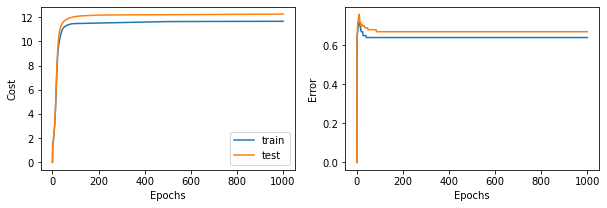

tensor(11.6671) tensor(12.2588) tensor(0.6400) tensor(0.6700)


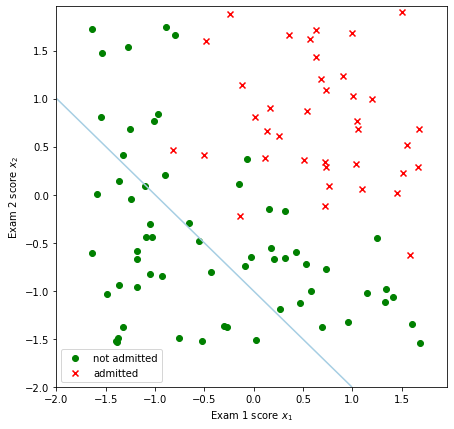

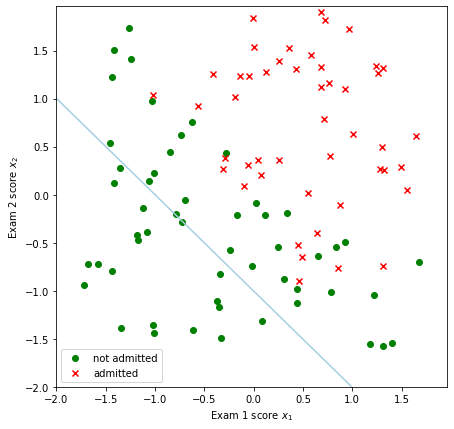

In [13]:
pol_degree1 = 1
nepochs = 1000
learningrate = 0.1

traincost1, testcost1, trainerror1, testerror1, W1 = evaluate(xtrain,ytrain,xtest,ytest,pol_degree1, nepochs, learningrate)
model1 = get_model(pol_degree1, W1)
plot_dataset(xtrain, ytrain, model1)
plot_dataset(xtest, ytest, model1)

1001


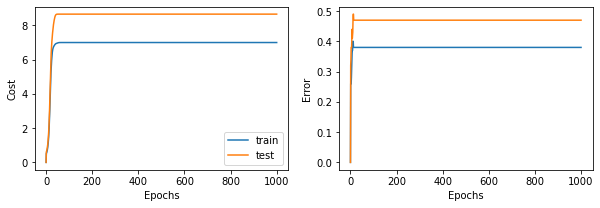

tensor(6.9999) tensor(8.6577) tensor(0.3800) tensor(0.4700)


/tmp/ipykernel_348/2113000405.py:13: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, yy.numpy(), levels=[0], cmap=plt.cm.Paired)


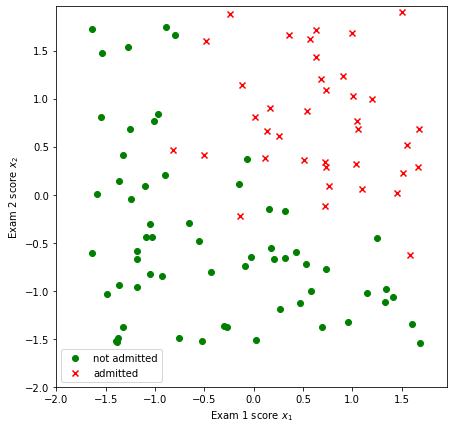

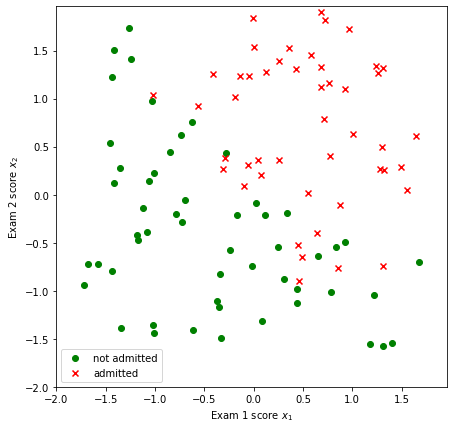

In [19]:
# runs with different degrees of polynomials....
pol_degree2 = 2
nepochs = 1000
learningrate = 0.1

traincost2, testcost2, trainerror2, testerror2, W2 = evaluate(xtrain,ytrain,xtest,ytest,pol_degree2, nepochs, learningrate)
model2 = get_model(pol_degree2, W2)
plot_dataset(xtrain, ytrain, model2)
plot_dataset(xtest, ytest, model2)

1001


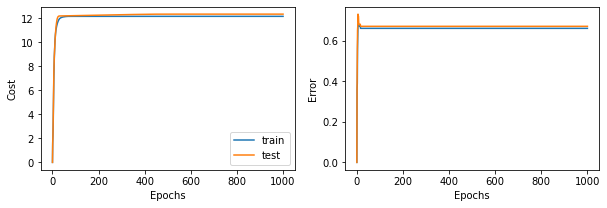

tensor(12.1576) tensor(12.3419) tensor(0.6600) tensor(0.6700)


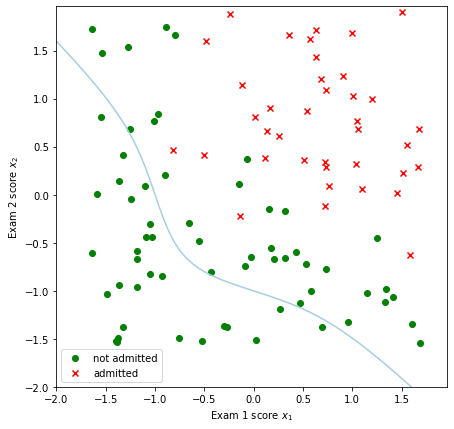

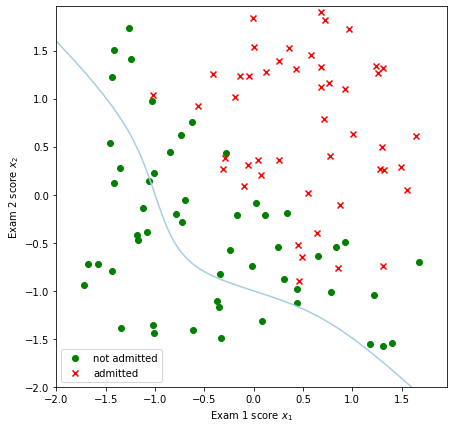

In [15]:
pol_degree3 = 5
nepochs = 1000
learningrate = 0.1

traincost3, testcost3, trainerror3, testerror3, W3 = evaluate(xtrain,ytrain,xtest,ytest,pol_degree3, nepochs, learningrate)
model3 = get_model(pol_degree3, W3)
plot_dataset(xtrain, ytrain, model3)
plot_dataset(xtest, ytest, model3)

1001


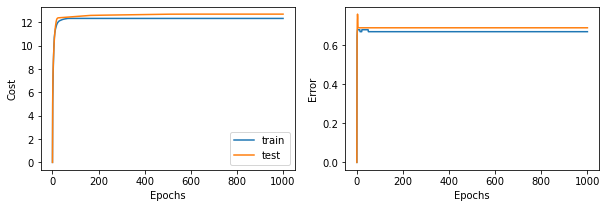

tensor(12.3419) tensor(12.7103) tensor(0.6700) tensor(0.6900)


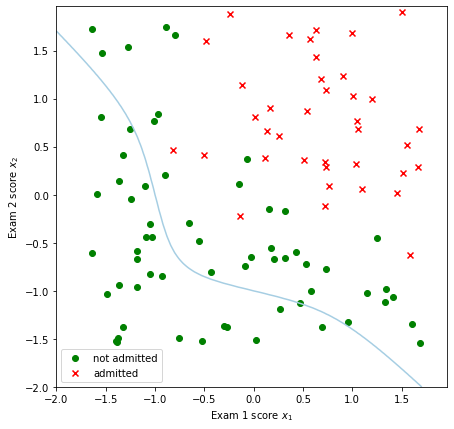

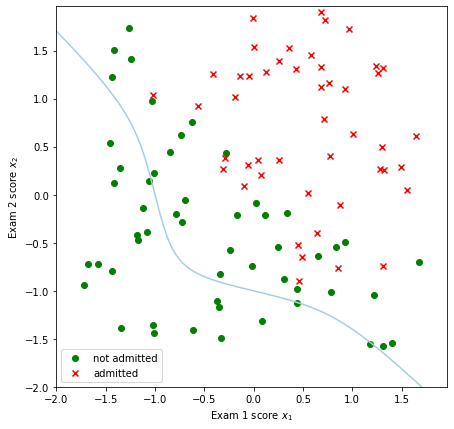

In [16]:
pol_degree4 = 7
nepochs = 1000
learningrate = 0.1

traincost4, testcost4, trainerror4, testerror4, W4 = evaluate(xtrain,ytrain,xtest,ytest,pol_degree4, nepochs, learningrate)
model4 = get_model(pol_degree4, W4)
plot_dataset(xtrain, ytrain, model4)
plot_dataset(xtest, ytest, model4)

1001


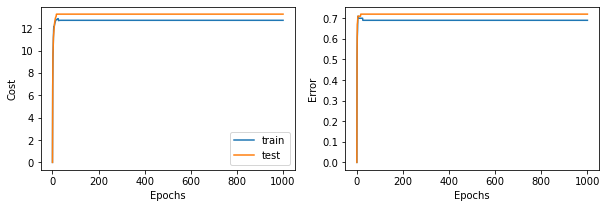

tensor(12.7103) tensor(13.2629) tensor(0.6900) tensor(0.7200)


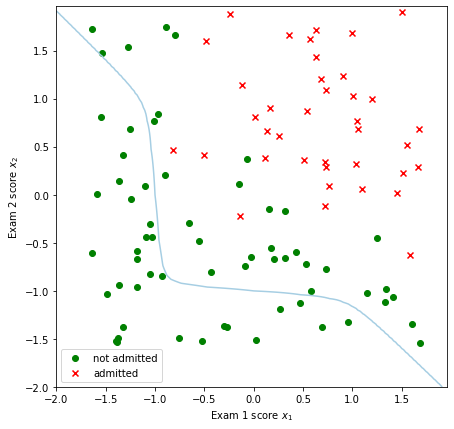

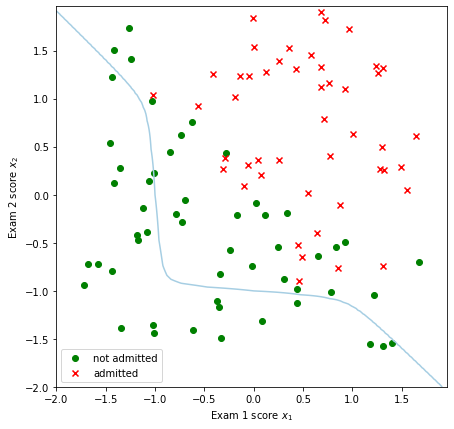

In [17]:
pol_degree5 = 25
nepochs = 1000
learningrate = 0.1

traincost5, testcost5, trainerror5, testerror5, W5 = evaluate(xtrain,ytrain,xtest,ytest,pol_degree5, nepochs, learningrate)
model5 = get_model(pol_degree5, W5)
plot_dataset(xtrain, ytrain, model5)
plot_dataset(xtest, ytest, model5)

In [18]:
# summary plot with the test and train errors vs degree of polynomial

.....

SyntaxError: invalid syntax (2714818138.py, line 3)